In [1]:
# Install PyTorch with GPU (CUDA) support
# For CUDA 12.1 (most common). For other versions, see https://pytorch.org
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cu121"])
print("PyTorch with CUDA 12.1 installed successfully!")

PyTorch with CUDA 12.1 installed successfully!


In [ ]:
# Ensure required packages are installed in the notebook environment
# (This magic installs packages into the active Jupyter kernel)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Transforms
IMG_SIZE = 512
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# 3. Data
# Load Public_dataset (contains: aluminium/, paper/, plastic/)
# Split into 80% train, 20% validation
data_dir = 'Public_dataset'

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Assign appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

image_datasets = {'train': train_dataset, 'val': val_dataset}

# Get class names
class_names = full_dataset.classes
NUM_CLASSES = len(class_names)
print(f"Classes: {class_names}")

# dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'), num_workers=2)
               for x in ['train', 'val']}

# 4. Model
# compatible with different torchvision versions
try:
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
except Exception:
    model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# 5. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# 6. Training and validation helpers
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    return epoch_loss, epoch_acc

# 7. Run training
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc = validate(model, dataloaders['val'], criterion, device)
    print(f"Epoch {epoch+1}/{EPOCHS} Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

# 8. Save
torch.save(model.state_dict(), 'resnet50_waste.pth')
print("Saved model: resnet50_waste.pth")

Using device: cpu
Classes: ['aluminium', 'paper', 'plastic']
Epoch 1/10 Train Loss 1.0237 Acc 0.4747 | Val Loss 0.9435 Acc 0.3333
Epoch 2/10 Train Loss 0.8125 Acc 0.6707 | Val Loss 0.6497 Acc 0.9000
Epoch 3/10 Train Loss 0.6955 Acc 0.7596 | Val Loss 0.5450 Acc 0.9333
Epoch 4/10 Train Loss 0.6515 Acc 0.7879 | Val Loss 0.4791 Acc 0.9667
Epoch 5/10 Train Loss 0.5745 Acc 0.7919 | Val Loss 0.4227 Acc 0.9667
Epoch 6/10 Train Loss 0.5386 Acc 0.8121 | Val Loss 0.4414 Acc 0.8333
Epoch 7/10 Train Loss 0.5319 Acc 0.7939 | Val Loss 0.4075 Acc 0.8333
Epoch 8/10 Train Loss 0.4725 Acc 0.8566 | Val Loss 0.3485 Acc 0.9333
Epoch 9/10 Train Loss 0.4536 Acc 0.8828 | Val Loss 0.3391 Acc 0.9667
Epoch 10/10 Train Loss 0.4412 Acc 0.8545 | Val Loss 0.2859 Acc 0.9667
Saved model: resnet50_waste.pth


In [4]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1. Load the model and weight
# Ensure NUM_CLASSES and model architecture match your training script
model.load_state_dict(torch.load('resnet50_waste.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

# 2. Collect predictions from the validation/test loader
print("Evaluating model...")
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Print the results
print("\n--- Project Evaluation Results ---")
print(f"Overall Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

# This prints Precision, Recall, and F1-score for each class (Plastic, Metal, Paper)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Evaluating model...

--- Project Evaluation Results ---
Overall Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

   aluminium       1.00      0.90      0.95        10
       paper       1.00      1.00      1.00        10
     plastic       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
[[ 9  0  1]
 [ 0 10  0]
 [ 0  0 10]]


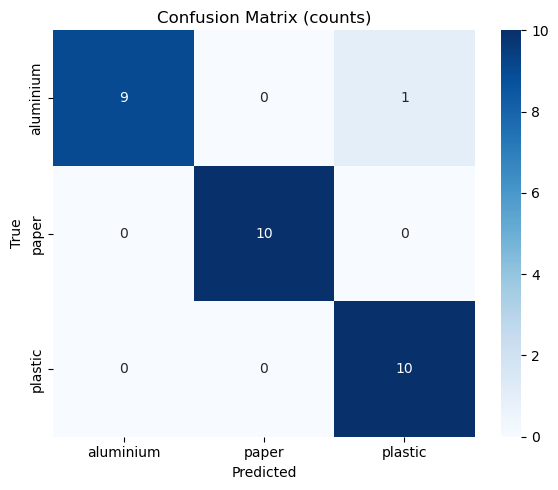

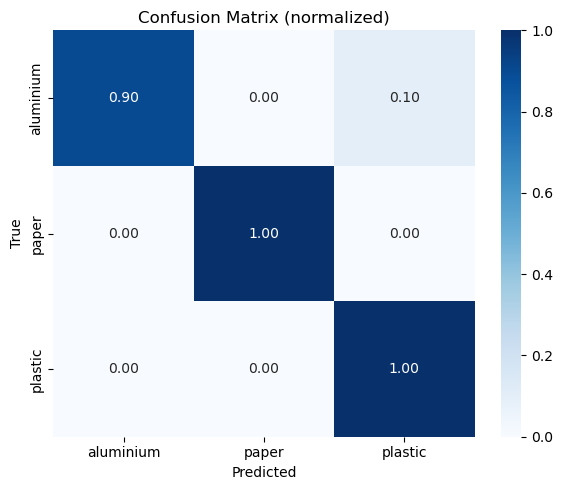

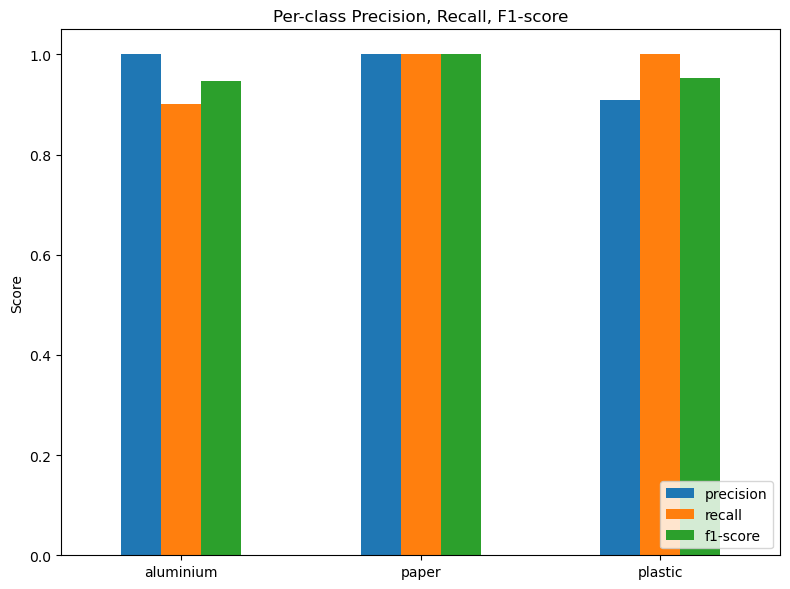


Per-class metrics:


,precision,recall,f1-score
aluminium,1.000000,0.9,0.947368
paper,1.000000,1.0,1.000000
plastic,0.909091,1.0,0.952381



Saved: classification_report.png
Saved: confusion_matrix.png


<Figure size 640x480 with 0 Axes>

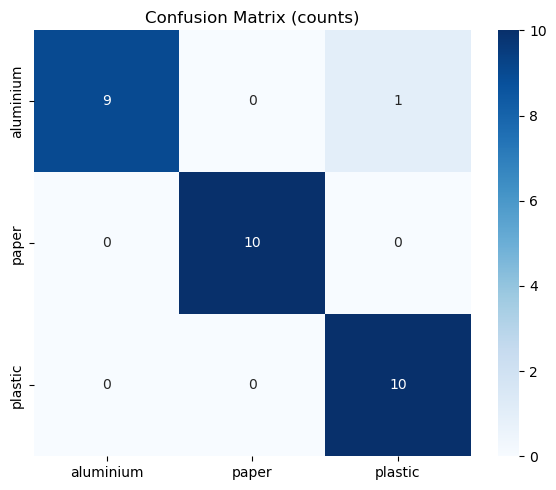

In [5]:
# --- New: Plot evaluation graphs (confusion matrix + per-class metrics)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Convert to numpy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

# 1) Confusion matrix (counts)
cm = confusion_matrix(all_labels_np, all_preds_np)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.tight_layout()
plt.show()

# 1b) Normalized confusion matrix (rows sum to 1)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (normalized)')
plt.tight_layout()
plt.show()

# 2) Classification report -> DataFrame
cr = classification_report(all_labels_np, all_preds_np, target_names=class_names, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()

# Select only class rows (in case averages are present)
classes = [c for c in class_names if c in cr_df.index]
classes_df = cr_df.loc[classes, ['precision', 'recall', 'f1-score']]

# 3) Plot per-class precision/recall/f1
ax = classes_df.plot(kind='bar', figsize=(8,6))
ax.set_title('Per-class Precision, Recall, F1-score')
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 4) Print table for quick reference
print('\nPer-class metrics:')
display(classes_df)

# 5) Save figures (optional)
try:
    plt.savefig('classification_report.png', dpi=150)
    print('\nSaved: classification_report.png')
except Exception:
    pass

# Save largest confusion matrix figure to file
try:
    fig = plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (counts)')
    plt.tight_layout()
    fig.savefig('confusion_matrix.png', dpi=150)
    print('Saved: confusion_matrix.png')
except Exception:
    pass

In [ ]:
# --- Evaluate trained model on `Dataset` 
import os
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load test dataset
TEST_DIR = 'Dataset'
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Test directory not found: {TEST_DIR}")

test_dataset = datasets.ImageFolder(TEST_DIR, transform=data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f'Training classes: {class_names}')
print(f'Test dataset ({TEST_DIR}) classes: {test_dataset.classes}')
print(f'Number of test samples: {len(test_dataset)}')

# Load trained weights
weights_path = 'resnet50_waste.pth'
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"✅ Loaded weights from {weights_path}")
else:
    raise FileNotFoundError(f"Weights file not found: {weights_path}")

model.to(device)
model.eval()

# Run inference
all_preds = []
all_labels = []
filenames = []

print("Running inference on test set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\n{'='*50}")
print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"{'='*50}")

# Classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('\nConfusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Dataset) - Accuracy: {acc:.4f}')
plt.tight_layout()
plt.show()

# Save predictions to CSV
pred_names = [class_names[p] for p in all_preds]
true_names = [class_names[l] for l in all_labels]
filenames = [fp for fp, _ in test_dataset.imgs]

results_df = pd.DataFrame({
    'filename': filenames,
    'true_label': true_names,
    'predicted_label': pred_names,
    'correct': (all_preds == all_labels)
})
results_df.to_csv('predictions_dataset.csv', index=False)
print(f'\n✅ Predictions saved to predictions_dataset.csv')